<a href="https://colab.research.google.com/github/gdeni89/Quant-GANs-deep-generation-of-financial-time-series/blob/main/Quant_GANs_deep_generation_of_financial_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading returns

In [ ]:
pip install yfinance 

In [ ]:
import yfinance as yf
data = yf.download(tickers ="^GSPC", start="2005-01-01", end="2021-01-01",interval = "1d") #SP500_daily
#ShanghaiSE_daily = yf.download(tickers ="HSI", start="2005-01-01", end="2021-01-01",interval = "1d")
data['Close'].head(5)

[*********************100%***********************]  1 of 1 completed


Date
2005-01-03    1202.079956
2005-01-04    1188.050049
2005-01-05    1183.739990
2005-01-06    1187.890015
2005-01-07    1186.189941
Name: Close, dtype: float64

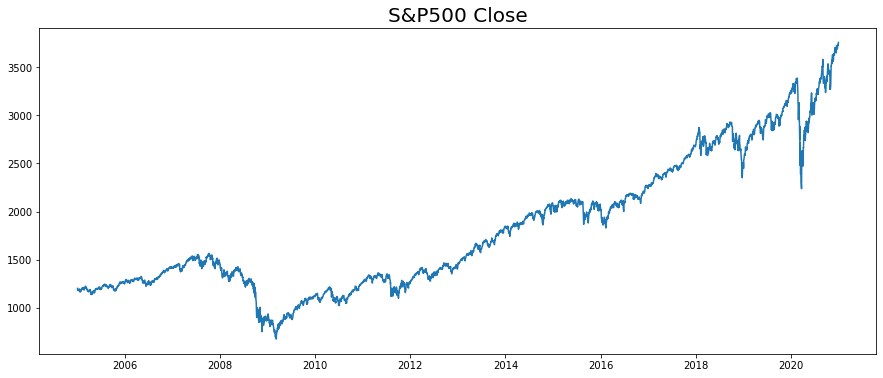

In [ ]:
from matplotlib import pylab as plt

df = data['Close']
fig = plt.figure(figsize=(15,6))
plt.title('S&P500 Close', fontsize=20)
plt.plot(data.index, data['Close'] )
plt.show()

##Preprocessing

In [ ]:
"""
Utility code

"""

import numpy as np
from sklearn.preprocessing import StandardScaler


def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries
    Args:
        x ([2d array]): x contains the time series in the shape (timestep, sample).
        k ([int]): window length.
        sparse (bool): Cut off the final windows containing NA. Defaults to True.
    Returns:
        [3d array]: array of rolling windows in the shape (window, timestep, sample).
    """    
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]
            
    if not sparse:
        return out

    return out[:, :-(k-1)]

def acf(x, k, le=False):

    
    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

def cross_acf(x, y, k, le=False):
    
    arr = rolling_window(y, k, sparse=False)
    a = (x - x.mean(axis=0))
    
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

In [ ]:
from typing import Text, List, Union

import numpy as np
from scipy import special
from scipy.stats import kurtosis, norm, rankdata, boxcox
from scipy import optimize  # TODO: Explore efficacy of other opt. methods
import sklearn
from matplotlib import pylab as plt
from scipy import stats
import warnings
import os

np.seterr(all='warn')


# Tolerance for == 0.0 tolerance.
_EPS = 1e-6


def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    elif len(x.shape) != 2:
        raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
    return x


class Gaussianize(sklearn.base.TransformerMixin):
    """
    Gaussianize data using various methods.
    Conventions
    ----------
    This class is a wrapper that follows sklearn naming/style (e.g. fit(X) to train).
    In this code, x is the input, y is the output. But in the functions outside the class, I follow
    Georg's convention that Y is the input and X is the output (Gaussianized) data.
    Parameters
    ----------
    
    strategy : str, default='lambert'. Possibilities are 'lambert'[1], 'brute'[2] and 'boxcox'[3].
    tol : float, default = 1e-4
    max_iter : int, default = 100
        Maximum number of iterations to search for correct parameters of Lambert transform.
    Attributes
    ----------
    coefs_ : list of tuples
        For each variable, we have transformation parameters.
        For Lambert, e.g., a tuple consisting of (mu, sigma, delta), corresponding to the parameters of the
        appropriate Lambert transform. Eq. 6 and 8 in the paper below.
    References
    ----------
    [1] Georg M Goerg. The Lambert Way to Gaussianize heavy tailed data with
                        the inverse of Tukey's h transformation as a special case
        Author generously provides code in R: https://cran.r-project.org/web/packages/LambertW/
    [2] Valero Laparra, Gustavo Camps-Valls, and Jesus Malo. Iterative Gaussianization: From ICA to Random Rotations
    [3] Box cox transformation and references: https://en.wikipedia.org/wiki/Power_transform
    """

    def __init__(self, strategy: Text = 'lambert', 
                 tol: float = 1e-5, 
                 max_iter: int = 100, 
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose
        
    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = _update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)
        
        if self.strategy == "lambert":
            _get_coef = lambda vec: igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = _update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([w_t(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
        """Show qq plots compared to normal before and after the transform."""
        x = _update_x(x)
        y = self.transform(x)
        n_dim = y.shape[1]
        for i in range(n_dim):
            stats.probplot(x[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
            plt.clf()
            stats.probplot(y[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
            plt.clf()


def w_d(z, delta):
    # Eq. 9
    if delta < _EPS:
        return z
    return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)


def w_t(y, tau):
    # Eq. 8
    return tau[0] + tau[1] * w_d((y - tau[0]) / tau[1], tau[2])


def inverse(x, tau):
    # Eq. 6
    u = (x - tau[0]) / tau[1]
    return tau[0] + tau[1] * (u * np.exp(u * u * (tau[2] * 0.5)))


def igmm(y: np.ndarray, tol: float = 1e-6, max_iter: int = 100):
    # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C
    if np.std(y) < _EPS:
        return np.mean(y), np.std(y).clip(_EPS), 0
    delta0 = delta_init(y)
    tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
    for k in range(max_iter):
        tau0 = tau1
        z = (y - tau1[0]) / tau1[1]
        delta1 = delta_gmm(z)
        x = tau0[0] + tau1[1] * w_d(z, delta1)
        mu1, sigma1 = np.mean(x), np.std(x)
        tau1 = (mu1, sigma1, delta1)

        if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
            break
        else:
            if k == max_iter - 1:
                warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
    return tau1


def delta_gmm(z):
    # Alg. 1, Appendix C
    delta0 = delta_init(z)

    def func(q):
        u = w_d(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        else:
            k = kurtosis(u, fisher=True, bias=False)**2
            if not np.isfinite(k) or k > 1e10:
                return 1e10
            else:
                return k

    res = optimize.fmin(func, np.log(delta0), disp=0)
    return np.around(np.exp(res[-1]), 6)


def delta_init(z):
    gamma = kurtosis(z, fisher=False, bias=False)
    with np.errstate(all='ignore'):
        delta0 = np.clip(1. / 66 * (np.sqrt(66 * gamma - 162.) - 6.), 0.01, 0.48)
    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0




In [ ]:
returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
data_size = log_returns.shape[0]
print(log_returns_preprocessed.shape)
print(data_size)

(4027, 1)
4027


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

class Loader32(Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

##Training the model


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """Creates a temporal block.
    Args:
        n_inputs (int): number of inputs.
        n_outputs (int): size of fully connected layers.
        kernel_size (int): kernel size along temporal axis of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers along temporal axis within the temporal block.
        padding (int): padding
        dropout (float): dropout rate
    Returns:
        tuple of output layers
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        if padding == 0:
            self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.5)
        self.conv2.weight.data.normal_(0, 0.5)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.5)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out, self.relu(out + res)



class Generator(nn.Module):
    """Generator: 3 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """ 
    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(3, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x


class Discriminator(nn.Module):
    """Discrimnator: 1 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """ 
    def __init__(self, seq_len, conv_dropout=0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
        self.to_prob = nn.Sequential(nn.Linear(seq_len, 1), nn.Sigmoid())

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return self.to_prob(x).squeeze()

In [ ]:
num_epochs = 100
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 0.0002

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev) 

In [ ]:
#%%capture
import os, sys
file_name = 'S&P500_daily'  
colab = 'COLAB_GPU' in os.environ
file_path = f'./{file_name}.csv'
generator_path = f'./train/'
if colab:
	from google.colab import files
	!pip install torch
	file_path = f'/content/Quant-GANs-deep-generation-of-financial-time-series/{file_name}.csv'
	generator_path = f'/content/Quant-GANs-deep-generation-of-financial-time-series/train/'
	username = "gdeni89"
	repository = "Quant-GANs-deep-generation-of-financial-time-series"
	!git clone https://github.com/{username}/{repository}.git
	sys.path.append('/content/Quant-GANs-deep-generation-of-financial-time-series/')

fatal: destination path 'Quant-GANs-deep-generation-of-financial-time-series' already exists and is not an empty directory.


In [ ]:
import torch.optim as optim
from tqdm import tqdm

generator = Generator().to(device)

train = True

if train:
    discriminator = Discriminator(seq_len).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    #dataset = Loader32(log_returns_preprocessed, 127)
    #dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    dataset = Loader32(log_returns_preprocessed, 1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):

            discriminator.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(1)
            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = generator(noise).detach()
            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()


Discriminator Loss: 0.00000000 Generator Loss: -0.50232887: 100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


##Visualizing results

In [13]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

77

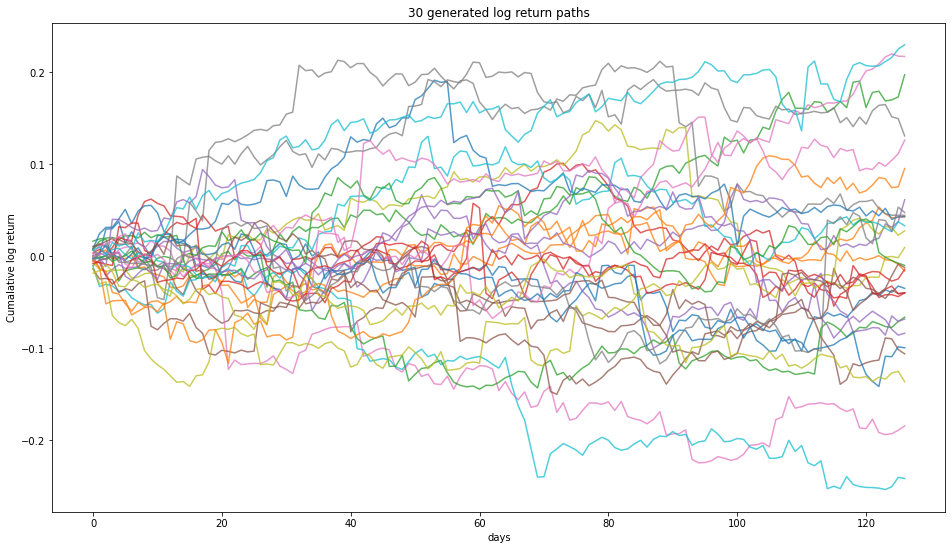

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

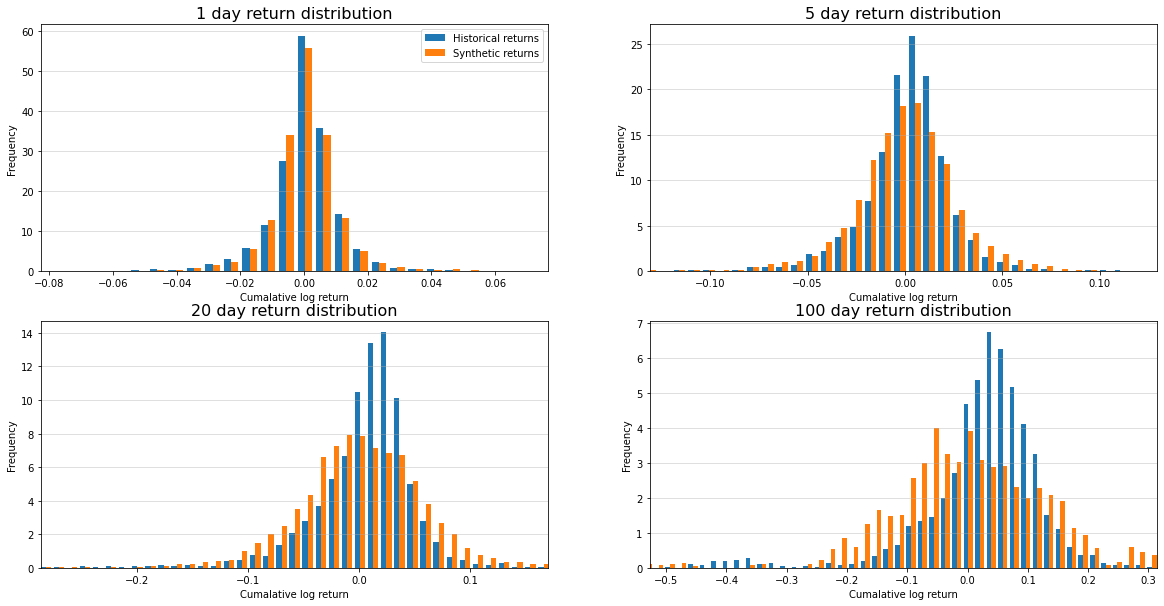

In [15]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])

[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

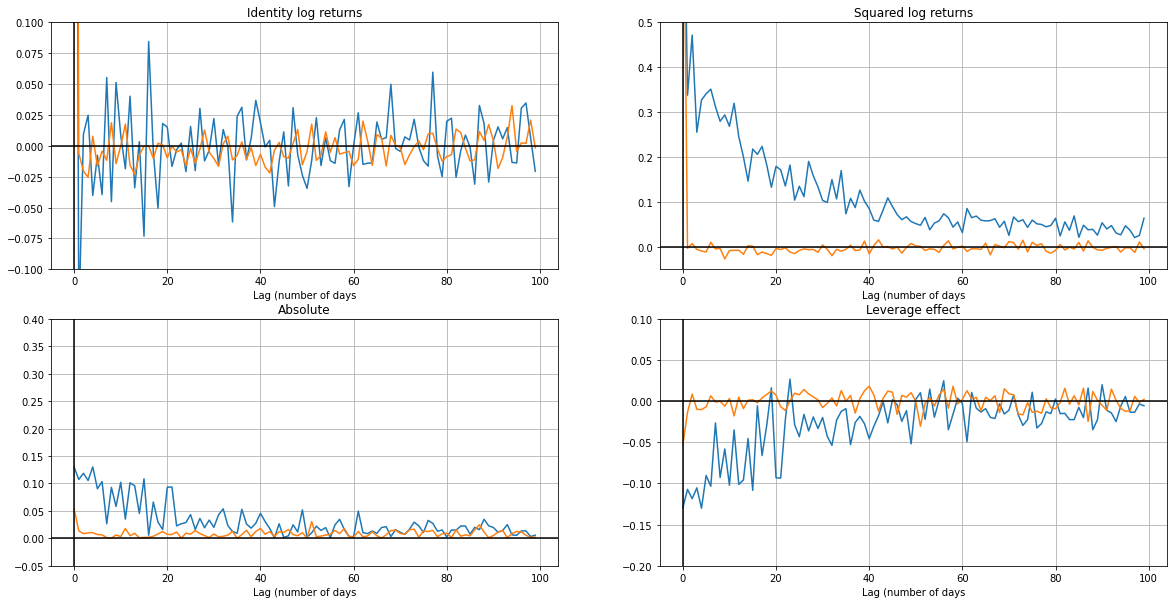

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')